In [27]:
import sys
sys.path.insert(0, '../../pyLDLE2/')

import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
import scipy as sp

import ConnectionNetworkX as cnx

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load puppets data and build connection graph

In [96]:
data_dir = "/data2/dhruv/PuppetsData/"

N_PUPPET_IMAGES = 500
NEAREST_NEIGHBORS = 13
INTRINSIC_DIMENSION = 2

puppetGraph = cnx.cnxFromImageDirectory(data_dir, INTRINSIC_DIMENSION,
                                        k=NEAREST_NEIGHBORS, nImages=N_PUPPET_IMAGES)

X.shape =  (8100, 100)
local_opts['k_nn0'] = 49 is created.
Options provided:
local_opts:
{
    "Atilde_method": "LDLE_1",
    "N": 100,
    "U_method": "k_nn",
    "algo": "LPCA",
    "alpha": 1,
    "debug": true,
    "delta": 0.9,
    "gl_type": "unnorm",
    "k": 13,
    "k_nn": 49,
    "k_nn0": 49,
    "k_tune": 7,
    "lambda1_decay": 0.75,
    "lambda1_init": 8,
    "lambda1_min": 0.001,
    "max_iter": 300,
    "max_sparsity": 0.9,
    "metric": "euclidean",
    "n_proc": 32,
    "p": 0.99,
    "power": 5,
    "pp_n_thresh": 32,
    "radius": 0.5,
    "reg": 0.0,
    "scale_by": "gamma",
    "tau": 50,
    "to_postprocess": true,
    "tuning": "self",
    "verbose": true
}
intermed_opts:
{
    "algo": "best",
    "debug": true,
    "eta_max": 1,
    "eta_min": 5,
    "len_S_thresh": 256,
    "local_algo": "LPCA",
    "n_proc": 32,
    "n_times": 4,
    "verbose": true
}
global_opts:
{
    "add_dim": false,
    "align_transform": "rigid",
    "align_w_parent_only": true,
    "al

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


Proportion of edges which were removed due to remoteness:  0.08005540166204986
[1.64799614 1.56580036 1.42860798 1.35999688 1.34566369 1.20163313
 1.0967842  1.06086416 0.98435948 0.94874497]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


# Set B, w, c, mu, nu

In [97]:
puppetB = puppetGraph.connectionIncidenceMatrix.T.astype('float32')
puppetW = np.ones(puppetB.shape[0]//INTRINSIC_DIMENSION).astype('float32')

np.random.seed(42)

#puppetMu = rand_prob_mass(puppetGraph.nNodes, INTRINSIC_DIMENSION)
#puppetNu = rand_prob_mass(puppetGraph.nNodes, INTRINSIC_DIMENSION)

puppetMu = np.zeros((puppetGraph.nNodes * INTRINSIC_DIMENSION,1))
puppetMu[0:2, :] = [[1],[1]]
puppetNu = np.zeros((puppetGraph.nNodes * INTRINSIC_DIMENSION,1))
puppetNu[2:4, :] = [[1],[1]]

puppetC = (puppetMu - puppetNu)

puppetC.reshape((puppetGraph.nNodes, INTRINSIC_DIMENSION))
puppetC.reshape((puppetGraph.nNodes, INTRINSIC_DIMENSION)).sum(axis=0)


array([0., 0.])

In [98]:
print(type(puppetC))
print(type(puppetB))
c_sol, residuals, _, _ = np.linalg.lstsq(sp.sparse.lil_matrix.toarray(puppetB.T), puppetC)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(puppetC.flatten() - puppetB.T.dot(c_sol).flatten())
#np.linalg.norm(c_sol)


<class 'numpy.ndarray'>
<class 'scipy.sparse._lil.lil_matrix'>


/tmp/ipykernel_8337/587698283.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(sp.sparse.lil_matrix.toarray(puppetB.T), puppetC)


7.483769280370744e-15

In [99]:
learning_rate = 0.1
alpha = 1
n_epochs = 3000

B = torch.tensor(sp.sparse.lil_matrix.toarray(puppetB))
w = torch.tensor(puppetW)
c = torch.tensor(puppetC.astype('float32'))
phi0 = -np.matmul(np.linalg.pinv(np.matmul(B.T, B)), c)
#phi0 = None

if phi0 is not None:
    print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B, w, c))

puppetPhi = cnx.optimize(B, w, c, alpha, learning_rate, n_epochs, phi0 = phi0)

/tmp/ipykernel_8337/4100503346.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B, w, c))
/home/dhruv/codebase/cgw/connection-graph-wasserstein/ConnectionNetworkX.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi0, requires_grad=True)


Initial loss: (tensor(0.3987), tensor(0.))
epoch: 0, loss: 0.398707, loss0: 0.398707, loss1: 0.000000
epoch: 10, loss: -3.197865, loss0: -3.540071, loss1: 0.684414
epoch: 20, loss: -4.643337, loss0: -5.282851, loss1: 1.279028
epoch: 30, loss: -4.729447, loss0: -5.214830, loss1: 0.970765
epoch: 40, loss: -4.764553, loss0: -5.141379, loss1: 0.753653
epoch: 50, loss: -4.781622, loss0: -5.194414, loss1: 0.825584
epoch: 60, loss: -4.787270, loss0: -5.204250, loss1: 0.833961
epoch: 70, loss: -4.788952, loss0: -5.208630, loss1: 0.839355
epoch: 80, loss: -4.789674, loss0: -5.207016, loss1: 0.834683
epoch: 90, loss: -4.790026, loss0: -5.205965, loss1: 0.831876
epoch: 100, loss: -4.790109, loss0: -5.205350, loss1: 0.830481
epoch: 110, loss: -4.790145, loss0: -5.206191, loss1: 0.832091
epoch: 120, loss: -4.790156, loss0: -5.206278, loss1: 0.832244
epoch: 130, loss: -4.790160, loss0: -5.206195, loss1: 0.832071
epoch: 140, loss: -4.790162, loss0: -5.206445, loss1: 0.832566
epoch: 150, loss: -4.7901

epoch: 1430, loss: -4.789589, loss0: -5.202131, loss1: 0.825085
epoch: 1440, loss: -4.789603, loss0: -5.202155, loss1: 0.825105
epoch: 1450, loss: -4.789605, loss0: -5.202122, loss1: 0.825035
epoch: 1460, loss: -4.789544, loss0: -5.201856, loss1: 0.824624
epoch: 1470, loss: -4.789544, loss0: -5.201815, loss1: 0.824543
epoch: 1480, loss: -4.789644, loss0: -5.202160, loss1: 0.825032
epoch: 1490, loss: -4.789654, loss0: -5.202166, loss1: 0.825024
epoch: 1500, loss: -4.789393, loss0: -5.201111, loss1: 0.823436
epoch: 1510, loss: -4.789579, loss0: -5.201763, loss1: 0.824369
epoch: 1520, loss: -4.789728, loss0: -5.202374, loss1: 0.825292
epoch: 1530, loss: -4.789489, loss0: -5.201370, loss1: 0.823762
epoch: 1540, loss: -4.789415, loss0: -5.201023, loss1: 0.823215
epoch: 1550, loss: -4.789728, loss0: -5.202233, loss1: 0.825011
epoch: 1560, loss: -4.789596, loss0: -5.201643, loss1: 0.824096
epoch: 1570, loss: -4.789238, loss0: -5.200175, loss1: 0.821875
epoch: 1580, loss: -4.789699, loss0: -5.

epoch: 2790, loss: -4.789915, loss0: -5.201288, loss1: 0.822747
epoch: 2800, loss: -4.789611, loss0: -5.199080, loss1: 0.818938
epoch: 2810, loss: -4.788316, loss0: -5.192279, loss1: 0.807925
epoch: 2820, loss: -4.789736, loss0: -5.200228, loss1: 0.820983
epoch: 2830, loss: -4.789731, loss0: -5.199626, loss1: 0.819791
epoch: 2840, loss: -4.788439, loss0: -5.192760, loss1: 0.808642
epoch: 2850, loss: -4.789498, loss0: -5.198363, loss1: 0.817730
epoch: 2860, loss: -4.789815, loss0: -5.200328, loss1: 0.821027
epoch: 2870, loss: -4.789127, loss0: -5.196179, loss1: 0.814105
epoch: 2880, loss: -4.789021, loss0: -5.195391, loss1: 0.812740
epoch: 2890, loss: -4.789857, loss0: -5.200961, loss1: 0.822208
epoch: 2900, loss: -4.789727, loss0: -5.199583, loss1: 0.819712
epoch: 2910, loss: -4.788340, loss0: -5.192171, loss1: 0.807663
epoch: 2920, loss: -4.789635, loss0: -5.199323, loss1: 0.819375
epoch: 2930, loss: -4.789783, loss0: -5.200118, loss1: 0.820669
epoch: 2940, loss: -4.788661, loss0: -5.

In [100]:
c_sol = cnx.active_edges(puppetPhi, B, w, c)
#c_sol = nabla_phi_norm(puppetPhi, B)
c_sol = c_sol.detach().numpy()

In [ ]:
J_opt = cnx.optimal_J(puppetPhi, B, w, alpha, INTRINSIC_DIMENSION).detach().numpy()

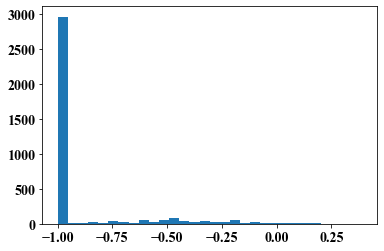

In [101]:
plt.figure()
plt.hist(c_sol, bins=30)
plt.show()

In [103]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
fit_obj = LocallyLinearEmbedding(n_components=INTRINSIC_DIMENSION, n_neighbors=15, method='ltsa')
# fit_obj = Isomap(n_components=INTRINSIC_DIMENSION+1, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
puppetGraph_embedding = fit_obj.fit_transform(puppetGraph.imageData)

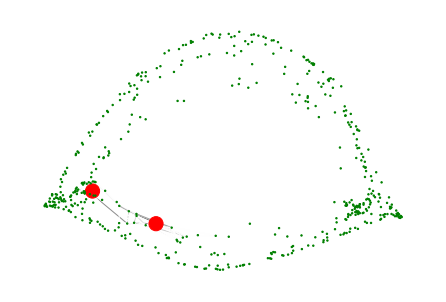

In [120]:
pos = {}
for i in range(puppetGraph.number_of_nodes()):
    pos[i] = puppetGraph_embedding[i,:]
    
node_size = np.ones(puppetGraph.number_of_nodes())*2
node_size[0] = 200
node_size[1] = 200
node_color = []
for i in range(puppetGraph.number_of_nodes()):
    node_color.append("g")
node_color[0] = "r"
node_color[1] = "r"

edge_color = np.linalg.norm(J_opt, axis=1)
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(puppetGraph, pos=pos, node_size=node_size, **options)

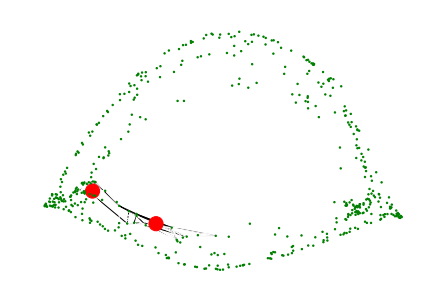

In [121]:
pos = {}
for i in range(puppetGraph.number_of_nodes()):
    pos[i] = puppetGraph_embedding[i,:]
    
node_size = np.ones(puppetGraph.number_of_nodes())*2
node_size[0] = 200
node_size[1] = 200
node_color = []
for i in range(puppetGraph.number_of_nodes()):
    node_color.append("g")
node_color[0] = "r"
node_color[1] = "r"

edge_color = (c_sol>0).astype('float')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(puppetGraph, pos=pos, node_size=node_size, **options)